In [102]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели
import matplotlib.pyplot as plt

In [103]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [104]:
df = pd.read_csv('main_task_new.csv')

In [105]:
df.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
6334,id_2740,Lisbon,NaN,2743.0,4.0,NaN,15.0,"[['nice bar', 'Nice atmosphere in the bar'], [...",/Restaurant_Review-g189158-d2615769-Reviews-Le...,d2615769
8576,id_12050,London,NaN,12060.0,4.0,NaN,5.0,"[['The Store of British tradition !', 'Could h...",/Restaurant_Review-g186338-d12328955-Reviews-M...,d12328955
5931,id_52,Stockholm,"['European', 'Swedish', 'Scandinavian', 'Veget...",53.0,4.0,$$$$,1314.0,"[['Great service, nice location, food didn’t.....",/Restaurant_Review-g189852-d878518-Reviews-Eri...,d878518
369,id_8227,Madrid,NaN,8234.0,3.0,NaN,2.0,"[[], []]",/Restaurant_Review-g187514-d5869951-Reviews-Ce...,d5869951
9322,id_838,Dublin,"['Italian', 'European', 'Mediterranean', 'Vege...",839.0,4.0,$$ - $$$,100.0,"[['Pasta Perfect', 'A very pleasant lunch!'], ...",/Restaurant_Review-g186605-d3199298-Reviews-L_...,d3199298


Подробнее по признакам:

City: Город

Cuisine Style: Кухня

Ranking: Ранг ресторана относительно других ресторанов в этом городе

Price Range: Цены в ресторане в 3 категориях

Number of Reviews: Количество отзывов

Reviews: 2 последних отзыва и даты этих отзывов

URL_TA: страница ресторана на 'www.tripadvisor.com'

ID_TA: ID ресторана в TripAdvisor

Rating: Рейтинг ресторана

### Очистка от NaN

In [106]:
#проверим, где есть пропуски
df.isna().sum()

Restaurant_id            0
City                     0
Cuisine Style         9283
Ranking                  0
Rating                   0
Price Range          13886
Number of Reviews     2543
Reviews                  0
URL_TA                   0
ID_TA                    0
dtype: int64

NaN имеются в 4 столбцах:

   1.  Cuisine Style
   2. Price Range
   3. Number of Reviews
   4. Reviews

In [107]:
#Cоздадим новые столбцы, в которых укажем, какие строки были пропущены
df['Number_of_Reviews_isNAN'] = pd.isna(df['Number of Reviews']).astype('uint8')
df['Cuisine Style_isNAN'] = pd.isna(df['Cuisine Style']).astype('uint8')
df['Price Range_isNAN'] = pd.isna(df['Price Range']).astype('uint8')
df['Reviews_isNAN'] = pd.isna(df['Reviews']).astype('uint8')

In [108]:
#Number of reviews
#Заполним пропуски наиболее часто встречающимся значением по городу
df['Number of Reviews'] = df.groupby('City')['Number of Reviews'].apply(lambda x: x.fillna(x.mean()))

In [109]:
#Cuisine Style
#Узнаем наиболее часто встречающееся значение и заполним им
#Значения в столбце преобразуем в тип "Список"
df['Cuisine Style'] = df['Cuisine Style'].apply(lambda x: x[1:-1] if type(x) == str else x)
df['Cuisine Style'] = df['Cuisine Style'].apply(lambda x: x.replace('\'', '') if type(x) == str else x)
df['Cuisine Style'] = df['Cuisine Style'].apply(lambda x: x.split(', ') if type(x) == str else x)

#вытащим список всех кухонь и посчитаем кол-во по каждому типу
all_cuisines = []
for row in df['Cuisine Style']:
    if type(row) == list:
        for i in row:
                all_cuisines.append(i)

all_cuisines = pd.DataFrame(all_cuisines)
all_cuisines[0].value_counts()

Vegetarian Friendly    11189
European               10060
Mediterranean           6277
Italian                 5964
Vegan Options           4486
                       ...  
Yunnan                     1
Xinjiang                   1
Latvian                    1
Burmese                    1
Salvadoran                 1
Name: 0, Length: 125, dtype: int64

In [110]:
#заполним пропуски самой часто встречающейся категорией
df['Cuisine Style']  =df['Cuisine Style'].fillna('Vegetarian Friendly')

In [111]:
#Price Range
#узнаем наиболее часто встречающуюся категорию
df['Price Range'].value_counts()

$$ - $$$    18412
$            6279
$$$$         1423
Name: Price Range, dtype: int64

In [112]:
#заменим прпоуски наиболее часто встречающейся категорий
df['Price Range'] = df['Price Range'].fillna('$$ - $$$')

In [113]:
#Reviews
#Узнаем наиболее часто встречающуся категорию
df['Reviews'].value_counts()

[[], []]                                                                                                                              6471
[['Good Lebanese food', 'Decent place'], ['07/19/2017', '03/17/2017']]                                                                   2
[['Simply Excellent!', 'Modern!'], ['10/22/2017', '08/29/2017']]                                                                         2
[['Very good all around', 'Our first Madrid restaurant'], ['11/20/2017', '10/11/2017']]                                                  2
[['Whenever in Madrid, we never miss this gem...', 'Underrated sushi restaurant with very good...'], ['04/11/2017', '12/02/2016']]       2
                                                                                                                                      ... 
[['Food tasty, service a miss', 'Terrible service wrong or overcooked food'], ['02/09/2017', '12/04/2017']]                              1
[['Awesome Sidewalk Cafe', 

In [114]:
#заменим фактически пропуски на значение Но Дата, и заполним ею пропуски
df['Reviews'] = df['Reviews'].str.replace('[[], []]', '[[no_data], [no_data]]')
df['Reviews'] = df['Reviews'].fillna('[[no_data], [no_data]]')

In [115]:
df.isna().sum()
#все пропуски обработаны

Restaurant_id              0
City                       0
Cuisine Style              0
Ranking                    0
Rating                     0
Price Range                0
Number of Reviews          0
Reviews                    0
URL_TA                     0
ID_TA                      0
Number_of_Reviews_isNAN    0
Cuisine Style_isNAN        0
Price Range_isNAN          0
Reviews_isNAN              0
dtype: int64

### Обработка признаков

In [116]:
#City
#для столбца City используем метод get_dummies
df = pd.get_dummies(df, columns=[ 'City',], dummy_na=True)

In [117]:
#Price Range
df['Price Range'].value_counts()


$$ - $$$    32298
$            6279
$$$$         1423
Name: Price Range, dtype: int64

In [118]:
def price_range(column):
    if column == '$':
        column = 0
    elif column == '$$ - $$$':
        column = 1
    elif column == '$$$$':
        column = 2
    return column


df['Price Range'] = df['Price Range'].apply(price_range)

In [119]:
#Cuisine Style
#Вытащим список всех кухонь
cuisines = []
for row in df['Cuisine Style']:
    if type(row) == list:
        for i in row:
             if i not in cuisines:
                cuisines.append(i)

#создадим фукцию по заполнению новух столбцов значением
def find_item(cell):
    if item in cell:
        return 1
    return 0

#применим функцию к каждому столбцу
for item in cuisines:
    df[item] = df['Cuisine Style'].apply(find_item)

In [120]:
#создадим новый признак по количеству кухонь 
df['number of cuisines'] = df['Cuisine Style'].apply(len)

In [121]:
#создадим новый признак "ЭТо сетевой ресторан или нет"
net = df.groupby(['Restaurant_id'])['ID_TA'].count() > 1
net = pd.DataFrame(net)
net = net[net['ID_TA'] == True]
net = list(net.index)
    
df['is_net'] = np.nan
for i in df.index:
    if df['Restaurant_id'][i] in net:
        df['is_net'][i] = 1
    else:
        df['is_net'][i] = 0

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [122]:
df['is_net'].sample(5)

30127    0.0
37549    1.0
3304     1.0
15788    1.0
21708    0.0
Name: is_net, dtype: float64

In [123]:
#Ranking
quartile1, quartile3 = np.percentile(df['Ranking'], [25, 75])
iqr = quartile3 - quartile1
lower_bound = quartile1 - (iqr * 1.5)
upper_bound = quartile3 + (iqr * 1.5)

outliers_ranking = df[(df['Ranking'] <= lower_bound) | (df['Ranking'] >= upper_bound)]

In [124]:
outliers_ranking = outliers_ranking['Ranking']

In [125]:
#создадим признак, является ли outliers_ranking вне границ iqr
df['ranking_is_out'] = np.nan
def func(row):
    if row in outliers_ranking:
        return 1
    else:
        return 0

In [126]:
df['ranking_is_out'] = df['Ranking'].apply(func)

### Распределение признаков

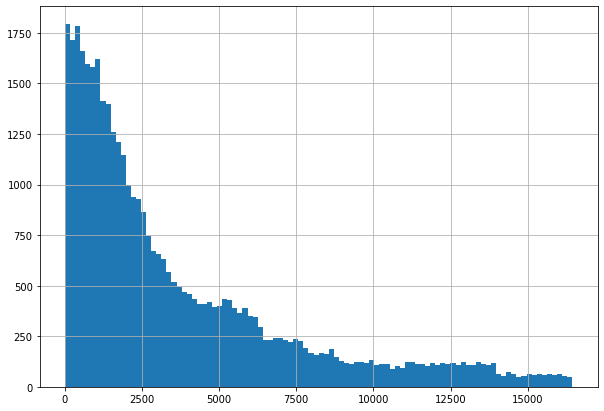

In [127]:
plt.rcParams['figure.figsize'] = (10,7)
df['Ranking'].hist(bins=100)

In [128]:
#df['City'].value_counts(ascending=True).plot(kind='barh')

KeyError: 'City'

In [129]:
#df['Ranking'][df['City'] =='London'].hist(bins=100)

In [130]:
# посмотрим на топ 10 городов
#for x in (df['City'].value_counts())[0:10].index:
 #   df['Ranking'][df['City'] == x].hist(bins=100)
#plt.show()

KeyError: 'City'

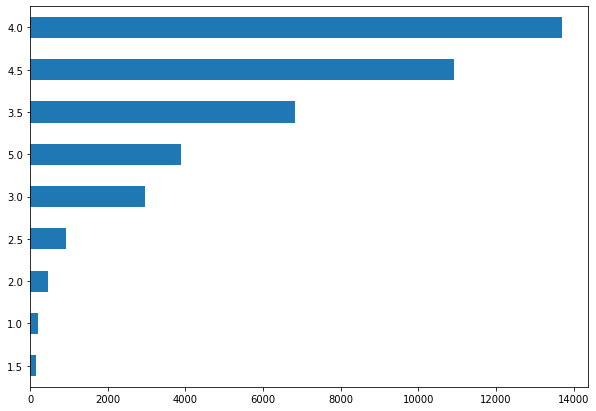

In [132]:
df['Rating'].value_counts(ascending=True).plot(kind='barh')

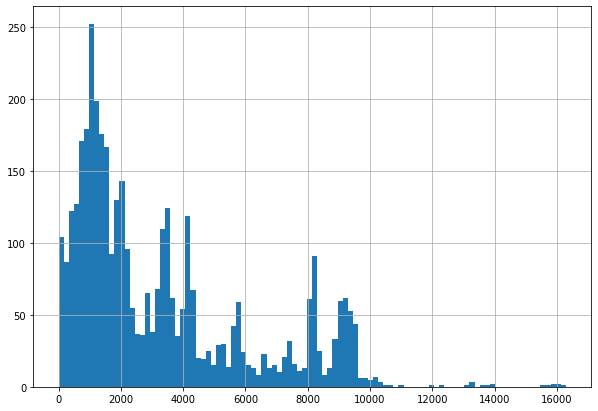

In [133]:
df['Ranking'][df['Rating'] == 5].hist(bins=100)

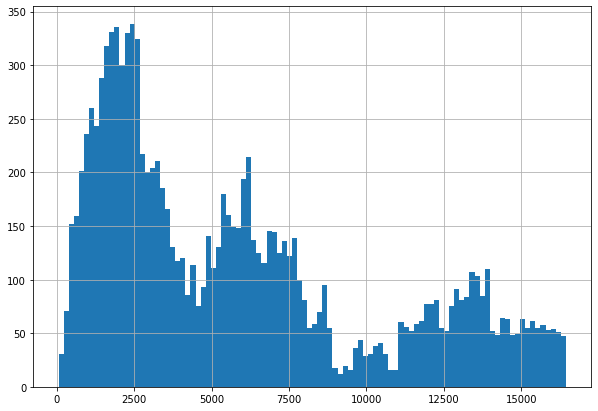

In [134]:
df['Ranking'][df['Rating'] < 4].hist(bins=100)

In [135]:
df.sample(5)

,Restaurant_id,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Number_of_Reviews_isNAN,...,Native American,Canadian,Xinjiang,Burmese,Fujian,Welsh,Latvian,number of cuisines,is_net,ranking_is_out
16027,id_7439,[Spanish],7440.0,2.5,1,361.0,"[['Average', 'Awkward service - very bad drink...",/Restaurant_Review-g187497-d6848843-Reviews-It...,d6848843,0,...,0,0,0,0,0,0,0,1,1.0,0
18271,id_2622,Vegetarian Friendly,2623.0,2.0,1,10.0,"[['Aperitif prior to dinner', 'disrespectful s...",/Restaurant_Review-g187265-d10524891-Reviews-L...,d10524891,0,...,0,0,0,0,0,0,0,19,1.0,0
3527,id_1343,Vegetarian Friendly,1344.0,5.0,1,10.0,"[['Awesome place for delicious cuisine', 'Grea...",/Restaurant_Review-g190454-d10026670-Reviews-O...,d10026670,0,...,0,0,0,0,0,0,0,19,1.0,0
34514,id_10362,"[Cafe, British, Pub, Vegetarian Friendly]",10371.0,4.0,0,9.0,"[['Hipster cafe with canal view.', 'Great plac...",/Restaurant_Review-g186338-d12502253-Reviews-W...,d12502253,0,...,0,0,0,0,0,0,0,4,0.0,0
24119,id_8688,Vegetarian Friendly,8690.0,5.0,1,7.0,"[[], []]",/Restaurant_Review-g187147-d5796659-Reviews-Cr...,d5796659,0,...,0,0,0,0,0,0,0,19,1.0,0


In [136]:
X = df.drop(['Rating', 'Cuisine Style', 'Reviews', 'URL_TA', 'Restaurant_id', 'ID_TA'], axis = 1)
y = df['Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.2160325
